In [1]:
#*********************Importing the packages required********************************
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from warnings import filterwarnings
filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import greater
import os
from matplotlib import pyplot as plt
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, SpatialDropout2D, BatchNormalization, Input, Activation, Dense, Flatten
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import plot_model
from keras.losses import binary_crossentropy
from keras.applications.vgg19 import VGG19
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,f1_score,recall_score
import seaborn as sns
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
import time
#****************************************************************************

In [2]:
#Loading the frontal face detector using cascadeClassifier
face_model = cv2.CascadeClassifier('../input/haar-cascades-for-face-detection/haarcascade_frontalface_default.xml')
#Method to plot the training history
def plot_loss_acc(history):
    #plt.plot(history.history['loss'],label='training loss')
    #plt.plot(history.history['val_loss'],label='validation loss')
    plt.plot(history.history['accuracy'],label='training accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.xlabel('# epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    
#Method to detect faces in input image and tell wheher face mask is worn or not
def detect_masks(img,model):
    mask_label = {1:'MASK',0:'NO MASK'}
    dist_label = {1:(0,255,0),0:(255,0,0)}
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)#converting the input image to greay image
    faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4) #returns coordinates of faces
    label = [0 for i in range(len(faces))]
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(HEIGHT,WEIGHT))
        crop = np.reshape(crop,[1,HEIGHT,WEIGHT,3])/255.0
        mask_result = model.predict_classes(crop) # checking if mask is worn or not
        #print(mask_result[0][0])
        cv2.putText(new_img,mask_label[mask_result[0][0]],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[mask_result[0][0]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[mask_result[0][0]],1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
    
#method to split the image data generator values into labels and X
def split_X_Y(gen):
    temp_x = []
    temp_y = []
    for i in range(gen.__len__()):
        tempnext = gen.next()
        temp_x.append(tempnext[0])
        temp_y.append(tempnext[1])
    x=np.concatenate(temp_x)
    y=np.concatenate(temp_y)
    return (x,y)

#Method to plot confusion metrix, accuracy,recall, and F1 score of model
def plot_confusion_matrix(model):
    ypred = model.predict_classes(x_test)
    sns.heatmap(confusion_matrix(ypred,y_test),annot=True,cbar=False,fmt = '.1f',xticklabels=['No Mask','Mask'],yticklabels=['No Mask','Mask'],cmap = 'Blues')
    title = 'Test Confusion Matrix, Accuracy:' + str(round(accuracy_score(ypred,y_test),4))
    plt.title(title,fontsize=18)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    print('Precision:' + str(round(precision_score(ypred,y_test),4)))
    print('Recall:' + str(round(recall_score(ypred,y_test),4)))
    print('F1 score:' + str(round(f1_score(ypred,y_test),4)))
#**************************************************************************

# Preprocessing

In [3]:
#********************Data preprocessing and preparation********************
#creating Imagedatagenerator for train data
train_data_generator = ImageDataGenerator(rescale=1./255,
                                         zoom_range=0.2,
                                         shear_range=0.2,
                                         horizontal_flip=True)
#creating Imagedatagenerator for test data
test_data_generator = ImageDataGenerator(rescale=1./255)
#creating Imagedatagenerator for val data
validation_data_generator = ImageDataGenerator(rescale=1./255,
                                         zoom_range=0.2,
                                         shear_range=0.2)

In [4]:
#loading the paths of dataset
train_dirs = "../input/face-mask-12k-images-dataset/Face Mask Dataset/Train"
test_dirs = "../input/face-mask-12k-images-dataset/Face Mask Dataset/Test"
validation_dirs = "../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation"
#Defining the input size
HEIGHT = 120
WEIGHT = 120
#To generate datasets or image augmentaion using imagedatagenerators created earlier
print("Flowing Train")
train_generator = train_data_generator.flow_from_directory(
        train_dirs,
        target_size=(HEIGHT,WEIGHT),
        batch_size=80,
        interpolation="nearest",
        class_mode='binary',
        classes=["WithoutMask","WithMask"])

print("\nFlowing Test")
test_generator = test_data_generator.flow_from_directory(
        test_dirs,
        target_size=(HEIGHT,WEIGHT),
        batch_size=80,
        interpolation="nearest",
        class_mode='binary',
        classes=["WithoutMask","WithMask"])

print("\nFlowing Validation")
validation_generator = validation_data_generator.flow_from_directory(
        validation_dirs,
        target_size=(HEIGHT,WEIGHT),
        batch_size=80,
        interpolation="nearest",
        class_mode='binary',
        classes=["WithoutMask","WithMask"])


Flowing Train
Found 10000 images belonging to 2 classes.

Flowing Test
Found 992 images belonging to 2 classes.

Flowing Validation
Found 800 images belonging to 2 classes.


In [5]:
#splitting train,test,val datasets into corresponding labels and X
x_train,y_train = split_X_Y(train_generator)
x_test,y_test = split_X_Y(test_generator)
x_val,y_val = split_X_Y(validation_generator)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
print(x_val.shape,y_val.shape)
#***********************************************************************

(10000, 120, 120, 3) (10000,)
(992, 120, 120, 3) (992,)
(800, 120, 120, 3) (800,)


# Model Building

In [6]:
#**********************Model buildng and training******************************
#Modified VGG19 model creation
def build_VGG19():
    vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(HEIGHT,WEIGHT,3))
    #To keep the layers untrainable
    for layer in vgg19.layers:
        layer.trainable = False
        
    model = Sequential()
    model.add(vgg19) #adding the VGG19 to the network
    model.add(Flatten()) #flatteing the features into vector
    model.add(Dense(1,activation='sigmoid')) #output layer
    model.summary()
    optimizer = Adam(lr=0.001) #optimizer with learnng rate
    model.compile(optimizer=optimizer,metrics =["accuracy"],loss = binary_crossentropy)
    #adding earlystopping and Reducer to stop training when further model improvement is not noticed
    reducer = ReduceLROnPlateau(monitor='loss',patience=3,factor=0.75,min_lr=0.000001,verbose=1)
    stopSign = EarlyStopping(monitor = "loss",patience=20,min_delta=0.000000000001,mode="min")
    epochs = 20
    batch_size = 32
    steps_per_epoch = x_train.shape[0] // batch_size
    #fitting the model using training data
    history = model.fit(x_train,y_train,
                        epochs = epochs, 
                        validation_data = (x_val,y_val),
                        verbose = 1,
                        batch_size=batch_size,
                        steps_per_epoch = steps_per_epoch,
                        callbacks=[reducer,stopSign])
    return history,model

#building modified MobileNetv2 model
def build_MobileNetv2():
    mobilenet = MobileNetV2(weights='imagenet',include_top=False,input_shape=(HEIGHT,WEIGHT,3))
    #setting the layers untrainable
    for layer in mobilenet.layers:
        layer.trainable = False
    model = Sequential()
    model.add(mobilenet) #adding mobilenet to network
    model.add(Flatten()) #creating the feature vector
    model.add(Dense(1,activation='sigmoid')) #output layer
    model.summary()
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer,metrics =["accuracy"],loss = binary_crossentropy)
    #adding earlystopping and reducer to stop training if training accuracy stops improving
    reducer = ReduceLROnPlateau(monitor='loss',patience=3,factor=0.75,min_lr=0.000001,verbose=1)
    stopSign = EarlyStopping(monitor = "loss",patience=20,min_delta=0.000000000001,mode="min")
    epochs = 20
    batch_size = 32
    steps_per_epoch = x_train.shape[0] // batch_size
    #fitting the model using training dataset
    history = model.fit(x_train,y_train,
                        epochs = epochs, 
                        validation_data = (x_val,y_val),
                        verbose = 1,
                        batch_size=batch_size,
                        steps_per_epoch = steps_per_epoch,
                        callbacks=[reducer,stopSign])
    return history,model

#building model with 1 CNN layer and 3 FC layers
def build_cnn_1():
        model = Sequential()
        
        model.add(Input(shape=(HEIGHT,WEIGHT,3,))) # adding input layer

        model.add(Conv2D(filters=16,kernel_size=(2,2),padding="same")) #adding CNN layer
        model.add(Activation("relu"))
        model.add(SpatialDropout2D(0.25))
        model.add(MaxPool2D(pool_size=(4,4))) #Max pooling

        model.add(Flatten()) #Flatteing the features into vector
        
        model.add(Dense(2048)) # 1st FC layer
        model.add(Activation("relu"))
        model.add(Dropout(0.25))
        
        model.add(Dense(1024)) #2nd FC layer
        model.add(Activation("relu"))
        model.add(Dropout(0.2))
        
        
        model.add(Dense(1)) # 3rd FC layer/output
        model.add(Activation("sigmoid"))
        
        optimizer = Adam(lr=0.001)
        model.compile(optimizer = optimizer ,metrics=["accuracy"], loss = binary_crossentropy)
        model.summary()
        #earlystoping and reducer to stop training if accuracy stops improving
        reducer = ReduceLROnPlateau(monitor='loss',patience=3,factor=0.75,min_lr=0.000001,verbose=1)
        stopSign = EarlyStopping(monitor = "loss",patience=20,min_delta=0.000000000001,mode="min")

        epochs = 20
        batch_size = 32
        steps_per_epoch = x_train.shape[0] // batch_size
        #fitting the model using training dataset
        history = model.fit(x_train,y_train,
                    epochs = epochs, 
                    validation_data = (x_val,y_val),
                    verbose = 1,
                    batch_size=batch_size,
                    steps_per_epoch = steps_per_epoch,
                    callbacks=[reducer,stopSign])
        
        return history,model

#Building model with 2 CNN layers and 3 FC layers
def build_cnn_2_3fl():
        model = Sequential()
        
        model.add(Input(shape=(HEIGHT,WEIGHT,3,))) #Input layer

        model.add(Conv2D(filters=16,kernel_size=(2,2),padding="same")) #1st CNN layer
        model.add(Activation("relu"))
        model.add(SpatialDropout2D(0.25))
        model.add(MaxPool2D(pool_size=(4,4)))

        model.add(Conv2D(filters=32,kernel_size=(2,2),padding="same")) #2nd CNN layer
        model.add(Activation("relu"))
        model.add(SpatialDropout2D(0.25))
        model.add(MaxPool2D(pool_size=(4,4),strides=(4,4)))
               
        model.add(Flatten()) #Vectorising the features
        
        model.add(Dense(2048)) #1st FC layer
        model.add(Activation("relu"))
        model.add(Dropout(0.25))
        
        model.add(Dense(1024)) #2nd FC layer
        model.add(Activation("relu"))
        model.add(Dropout(0.2))
        
        
        model.add(Dense(1)) #3rd FC layer/output
        model.add(Activation("sigmoid"))
        
        optimizer = Adam(lr=0.001)
        model.compile(optimizer = optimizer ,metrics=["accuracy"], loss = binary_crossentropy)
        model.summary()
        reducer = ReduceLROnPlateau(monitor='loss',patience=3,factor=0.75,min_lr=0.000001,verbose=1)
        stopSign = EarlyStopping(monitor = "loss",patience=20,min_delta=0.000000000001,mode="min")
        epochs = 20
        batch_size = 32
        steps_per_epoch = x_train.shape[0] // batch_size
        #fitting the model using training data
        history = model.fit(x_train,y_train,
                    epochs = epochs, 
                    validation_data = (x_val,y_val),
                    verbose = 1,
                    batch_size=batch_size,
                    steps_per_epoch = steps_per_epoch,
                    callbacks=[reducer,stopSign])
        
        return history,model
    
#Building model with 2 CNN layers and 2 FC layers
def build_cnn_2_2fl():
        model = Sequential()
        
        model.add(Input(shape=(HEIGHT,WEIGHT,3,))) #Input layer

        model.add(Conv2D(filters=16,kernel_size=(2,2),padding="same"))#1st CNN layer
        model.add(Activation("relu"))
        model.add(SpatialDropout2D(0.25))
        model.add(MaxPool2D(pool_size=(4,4)))

        model.add(Conv2D(filters=32,kernel_size=(2,2),padding="same"))#2nd CNN layer
        model.add(Activation("relu"))
        model.add(SpatialDropout2D(0.25))
        model.add(MaxPool2D(pool_size=(4,4),strides=(4,4)))
               
        model.add(Flatten())
        
        model.add(Dense(1024)) #1st FC layer
        model.add(Activation("relu"))
        model.add(Dropout(0.2))
        
        
        model.add(Dense(1)) #2nd FC layer
        model.add(Activation("sigmoid"))
        
        optimizer = Adam(lr=0.001)
        model.compile(optimizer = optimizer ,metrics=["accuracy"], loss = binary_crossentropy)
        model.summary()
        reducer = ReduceLROnPlateau(monitor='loss',patience=3,factor=0.75,min_lr=0.000001,verbose=1)
        stopSign = EarlyStopping(monitor = "loss",patience=20,min_delta=0.000000000001,mode="min")
        epochs = 20
        batch_size = 32
        steps_per_epoch = x_train.shape[0] // batch_size
        #fitting the model using taining dataset
        history = model.fit(x_train,y_train,
                    epochs = epochs, 
                    validation_data = (x_val,y_val),
                    verbose = 1,
                    batch_size=batch_size,
                    steps_per_epoch = steps_per_epoch,
                    callbacks=[reducer,stopSign])
        
        return history,model

#buildng the model with 3 CNN layers and 3 FC layers
def build_cnn_3():
    model = Sequential()

    model.add(Input(shape=(HEIGHT,WEIGHT,3,))) #input layer

    model.add(Conv2D(filters=16,kernel_size=(2,2),padding="same")) #1st CNN layer
    model.add(Activation("relu"))
    model.add(SpatialDropout2D(0.25))
    model.add(MaxPool2D(pool_size=(4,4)))

    model.add(Conv2D(filters=16,kernel_size=(2,2),padding="same")) #2nd CNN layer
    model.add(Activation("relu"))
    model.add(SpatialDropout2D(0.25))
    model.add(MaxPool2D(pool_size=(4,4)))

    model.add(Conv2D(filters=16,kernel_size=(2,2),padding="same")) #3rd CNN layer
    model.add(Activation("relu"))
    model.add(SpatialDropout2D(0.25))
    model.add(MaxPool2D(pool_size=(4,4),strides=(4,4)))

    model.add(Flatten())

    model.add(Dense(2048)) #1st FC layer
    model.add(Activation("relu"))
    model.add(Dropout(0.25))

    model.add(Dense(1024)) #2nd FC layer
    model.add(Activation("relu"))
    model.add(Dropout(0.2))


    model.add(Dense(1)) #3rd FC layer/output layer
    model.add(Activation("sigmoid"))

    optimizer = Adam(lr=0.001)
    model.compile(optimizer = optimizer ,metrics=["accuracy"], loss = binary_crossentropy)
    model.summary()
    reducer = ReduceLROnPlateau(monitor='loss',patience=3,factor=0.75,min_lr=0.000001,verbose=1)
    stopSign = EarlyStopping(monitor = "loss",patience=20,min_delta=0.000000000001,mode="min")
    epochs = 20
    batch_size = 32
    steps_per_epoch = x_train.shape[0] // batch_size
    #fitting the model using train dataset
    history = model.fit(x_train,y_train,
                epochs = epochs, 
                validation_data = (x_val,y_val),
                verbose = 1,
                batch_size=batch_size,
                steps_per_epoch = steps_per_epoch,
                callbacks=[reducer,stopSign])

    return history,model
#*******************************************************************

80142336/80134624 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 3, 3, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 4609      
Total params: 20,028,993
Trainable params: 4,609
Non-trainable params: 20,024,384
_________________________________________________________________
Epoch 1/20
312/312 [==============================] - 9s 30ms/step - loss: 0.1394 - accuracy: 0.9549 - val_loss: 0.0754 - val_accuracy: 0.9787
Epoch 2/20
312/312 [==============================] - 9s 28ms/step - loss: 0.0545 - accuracy: 0.9846 - val_loss: 0.0487 - val_accuracy: 0.9837
Epoch 3/20
312/312 

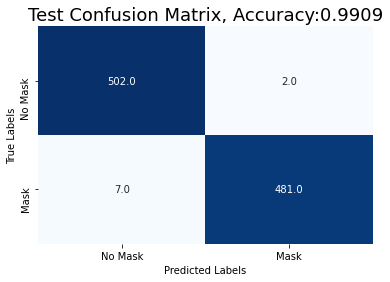

In [7]:
#********************Transfer Lerning using VGG19********************
start = time.time()
history_VGG19,model_VGG19 = build_VGG19() #building model
end = time.time()
print("Training time:" + str(end - start))
start = time.time()
model_VGG19.evaluate(x_test,y_test) #Evaluating model
end = time.time()
print("Testing time:" + str(end - start))
plot_confusion_matrix(model_VGG19) #displaying evaluation metrics
#********************************************************************

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 20480)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 20481     
Total params: 2,278,465
Trainable params: 20,481
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/20
312/312 [==============================] - 5s 16ms/step - loss: 0.0601 - accuracy: 0.9869 - val_loss: 0.0169 - val_accuracy: 0.9950
Epoch 2/20
312/312 [==============================] - 4s 13ms/step - loss: 0.0161 - accuracy: 0.9964 - val_loss: 0.0267 - val_accuracy: 0.9975
Epoch 3/20
312/312 [

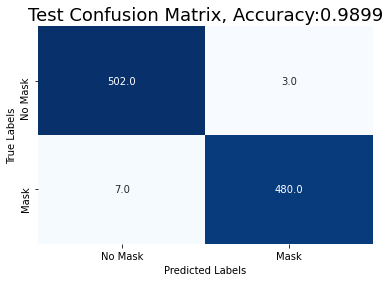

In [8]:
#********************Transfer Lerning using MobileNetV2********************
start = time.time()
history_mobnet,model_mobnet = build_MobileNetv2() #building model
end = time.time()
print("Training time:" + str(end - start))
start = time.time()
model_mobnet.evaluate(x_test,y_test) #evaluating model
end = time.time()
print("Testing time:" + str(end - start))
plot_confusion_matrix(model_mobnet) #displaying evaluation metrics
#***************************************************************************

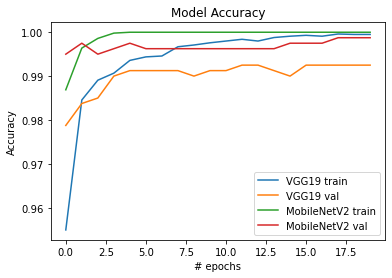

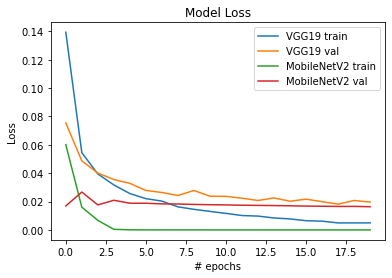

In [9]:
#********************transfer learning-training accuracy and loss***************
plt.plot(history_VGG19.history['accuracy'],label='VGG19 train')
plt.plot(history_VGG19.history['val_accuracy'],label='VGG19 val')
plt.plot(history_mobnet.history['accuracy'],label='MobileNetV2 train')
plt.plot(history_mobnet.history['val_accuracy'],label='MobileNetV2 val')
plt.xlabel('# epochs')
plt.ylabel('Accuracy')
plt.title("Model Accuracy")
plt.legend()
plt.show()

plt.plot(history_VGG19.history['loss'],label='VGG19 train')
plt.plot(history_VGG19.history['val_loss'],label='VGG19 val')
plt.plot(history_mobnet.history['loss'],label='MobileNetV2 train')
plt.plot(history_mobnet.history['val_loss'],label='MobileNetV2 val')
plt.xlabel('# epochs')
plt.title("Model Loss")
plt.ylabel('Loss')
plt.legend()
plt.show()
#**********************************************************************

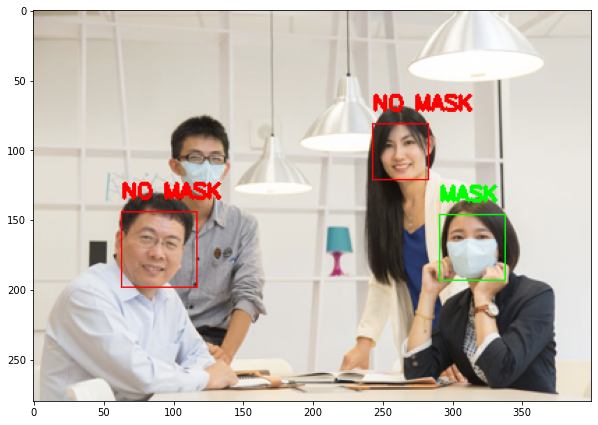

In [10]:
#loading image to detect face mask
img_path = '/kaggle/input/d/andrewmvd/face-mask-detection/images/maksssksksss96.png'
#calling method to detect mask
detect_masks(img_path,model_VGG19)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 120, 16)      208       
_________________________________________________________________
activation (Activation)      (None, 120, 120, 16)      0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 120, 120, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 14400)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              29493248  
_________________________________________________________________
activation_1 (Activation)    (None, 2048)             

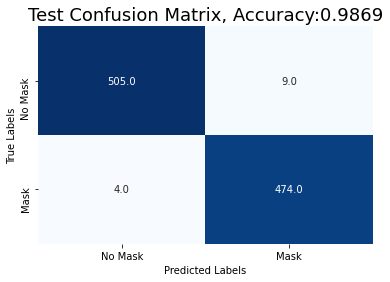

In [11]:
#********************Model with 1 CNN and 3 FC********************
start = time.time()
history_cnn1,model_cnn1 = build_cnn_1()
end = time.time()
print("Training time:" + str(end - start))
start = time.time()
model_cnn1.evaluate(x_test,y_test)
end = time.time()
print("Testing time:" + str(end - start))
plot_confusion_matrix(model_cnn1)
#*****************************************************************

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 120, 120, 16)      208       
_________________________________________________________________
activation_4 (Activation)    (None, 120, 120, 16)      0         
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 120, 120, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        2080      
_________________________________________________________________
activation_5 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
spatial_dropout2d_2 (Spatial (None, 30, 30, 32)       

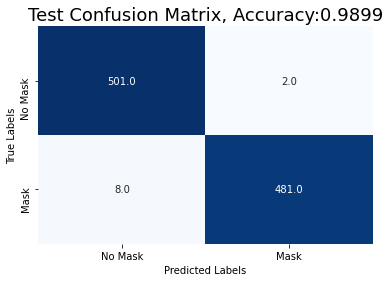

In [12]:
#********************Model with 2 CNN and 2 FC********************
start = time.time()
history_cnn2_1,model_cnn2_1 = build_cnn_2_2fl()
end = time.time()
print("Training time:" + str(end - start))
start = time.time()
model_cnn2_1.evaluate(x_test,y_test)
end = time.time()
print("Testing time:" + str(end - start))
plot_confusion_matrix(model_cnn2_1)
#*****************************************************************

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 120, 120, 16)      208       
_________________________________________________________________
activation_8 (Activation)    (None, 120, 120, 16)      0         
_________________________________________________________________
spatial_dropout2d_3 (Spatial (None, 120, 120, 16)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 32)        2080      
_________________________________________________________________
activation_9 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
spatial_dropout2d_4 (Spatial (None, 30, 30, 32)       

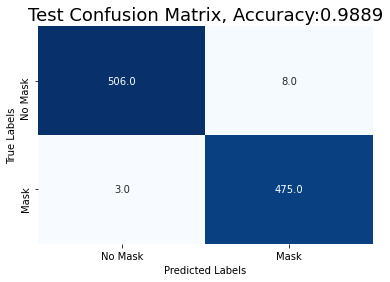

In [13]:
#********************Model with 2 CNN and 3 FC********************
start = time.time()
history_cnn2_2,model_cnn2_2 = build_cnn_2_3fl()
end = time.time()
print("Training time:" + str(end - start))
start = time.time()
model_cnn2_2.evaluate(x_test,y_test)
end = time.time()
print("Testing time:" + str(end - start))
plot_confusion_matrix(model_cnn2_2)
#*****************************************************************


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 120, 120, 16)      208       
_________________________________________________________________
activation_13 (Activation)   (None, 120, 120, 16)      0         
_________________________________________________________________
spatial_dropout2d_5 (Spatial (None, 120, 120, 16)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 16)        1040      
_________________________________________________________________
activation_14 (Activation)   (None, 30, 30, 16)        0         
_________________________________________________________________
spatial_dropout2d_6 (Spatial (None, 30, 30, 16)       

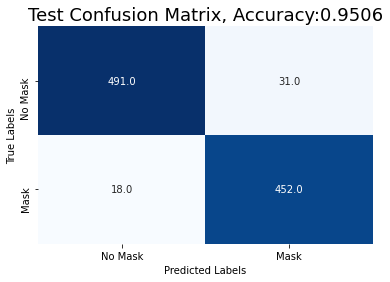

In [14]:
#********************Model with 3 CNN and 3 FC********************
start = time.time()
history_cnn3,model_cnn3 = build_cnn_3()
end = time.time()
print("Training time:" + str(end - start))
start = time.time()
model_cnn3.evaluate(x_test,y_test)
end = time.time()
print("Testing time:" + str(end - start))
plot_confusion_matrix(model_cnn3)
#******************************************************************


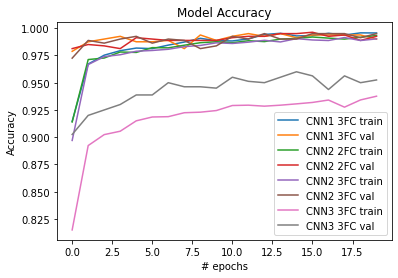

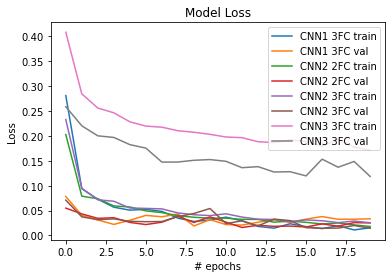

In [15]:
#********************CNN training accuracy and loss********************
plt.plot(history_cnn1.history['accuracy'],label='CNN1 3FC train')
plt.plot(history_cnn1.history['val_accuracy'],label='CNN1 3FC val')
plt.plot(history_cnn2_1.history['accuracy'],label='CNN2 2FC train')
plt.plot(history_cnn2_1.history['val_accuracy'],label='CNN2 2FC val')
plt.plot(history_cnn2_2.history['accuracy'],label='CNN2 3FC train')
plt.plot(history_cnn2_2.history['val_accuracy'],label='CNN2 3FC val')
plt.plot(history_cnn3.history['accuracy'],label='CNN3 3FC train')
plt.plot(history_cnn3.history['val_accuracy'],label='CNN3 3FC val')
plt.xlabel('# epochs')
plt.ylabel('Accuracy')
plt.title("Model Accuracy")
plt.legend()
plt.show()

plt.plot(history_cnn1.history['loss'],label='CNN1 3FC train')
plt.plot(history_cnn1.history['val_loss'],label='CNN1 3FC val')
plt.plot(history_cnn2_1.history['loss'],label='CNN2 2FC train')
plt.plot(history_cnn2_1.history['val_loss'],label='CNN2 2FC val')
plt.plot(history_cnn2_2.history['loss'],label='CNN2 3FC train')
plt.plot(history_cnn2_2.history['val_loss'],label='CNN2 3FC val')
plt.plot(history_cnn3.history['loss'],label='CNN3 3FC train')
plt.plot(history_cnn3.history['val_loss'],label='CNN3 3FC val')
plt.xlabel('# epochs')
plt.title("Model Loss")
plt.ylabel('Loss')
plt.legend()
plt.show()
#***********************************************************************

# Using CNN AutoEncoders

In [16]:
#********************Future research using AutoEncoders********************
# import keras
# from keras import layers
# input_img = keras.Input(shape=(HEIGHT,WEIGHT,3,))
# def encode_cnn_ae():
# #     x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
# #     x = layers.MaxPooling2D((4, 4), padding='same')(x)
#     x = layers.Conv2D(3, (3, 3), activation='relu', padding='same')(input_img)
#     encoded = layers.MaxPooling2D((4, 4), padding='same')(x)
# #     x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# #     encoded = layers.MaxPooling2D((4, 4), padding='same')(x)
#     return encoded

# def decode_cnn_ae(encoded):
# #     x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
# #     x = layers.UpSampling2D((4, 4))(x)
#     x = layers.Conv2D(3, (3, 3), activation='relu', padding='same')(encoded)
#     decoded = layers.UpSampling2D((4, 4))(x)
# #     x = layers.Conv2D(16, (3, 3), activation='relu')(x)
# #     x = layers.UpSampling2D((4, 4))(x)
# #     decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
#     return decoded

# def fully_connected(enco):
#     flat = Flatten()(enco)
#     den = Dense(2048, activation='relu')(flat)
#     den1 = Dense(1024, activation='relu')(den)
#     out = Dense(1, activation='softmax')(den1)
#     return out


In [17]:
# autoencoder = keras.Model(input_img, decode_cnn_ae(encode_cnn_ae()))
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [18]:
# autoencoder.summary()

In [19]:
# autoencoder.layers

In [20]:
# trained_ae = autoencoder.fit(x_train, x_train,
#                 epochs=20,
#                 batch_size=128,
#                 shuffle=True,
#                 validation_data=(x_val, x_val))

In [21]:
# encoder = encode_cnn_ae()
# full_model = keras.Model(input_img,fully_connected(encoder))

In [22]:
# full_model.summary()

In [23]:
# ### set fully conected veights for the required layers same as encoder decoder part
# for l1,l2 in zip(full_model.layers[:3],autoencoder.layers[0:3]):
#     l1.set_weights(l2.get_weights())
# # set encoder part veights not trainable
# for layer in full_model.layers:
#     layer.trainable = False

# #Compile the fully connected model
# full_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
# full_model.summary()
# #Train the fuly connected model to learn the lables and classification
# classify_train = full_model.fit(x_train, y_train, epochs=20,verbose=1)#, batch_size=64

In [24]:
# decoded_imgs = autoencoder.predict(x_test)

# n = 4
# plt.figure(figsize=(10, 4))
# for i in range(1, n + 1):
#     # Display original
#     ax = plt.subplot(2, n, i)
#     plt.imshow(x_test[i])
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)

#     # Display reconstruction
#     ax = plt.subplot(2, n, i + n)
#     plt.imshow(decoded_imgs[i])
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
# plt.show()

In [25]:
# full_model.evaluate(x_test,y_test)

In [26]:
# pred = full_model.predict(x_train)
# pred

In [27]:
# from tensorflow.keras.layers import LeakyReLU
# from tensorflow.keras.models import Model
# # encoder level 1
# e = Dense(2000)(input_img)
# e = BatchNormalization()(e)
# e = LeakyReLU()(e)
# # encoder level 2
# e = Dense(1000)(e)
# e = BatchNormalization()(e)
# e = LeakyReLU()(e)
# # bottleneck
# #n_bottleneck = round(float(1000) / 2.0)
# bottleneck = Dense(1000)(e)
# # define decoder, level 1
# d = Dense(1000)(bottleneck)
# d = BatchNormalization()(d)
# d = LeakyReLU()(d)
# # decoder level 2
# d = Dense(2000)(d)
# d = BatchNormalization()(d)
# d = LeakyReLU()(d)
# # output layer
# output = Dense(1, activation='softmax')(d)
# # define autoencoder model
# model = Model(inputs=input_img, outputs=output)
# # compile autoencoder model
# model.compile(optimizer='adam', loss='mse')
# # plot the autoencoder
# # fit the autoencoder model to reconstruct input
# history = model.fit(x_train, x_train, epochs=200, batch_size=16, verbose=2, validation_data=(x_val,x_val))
# # plot loss
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()
# # define an encoder model (without the decoder)
# encoder = Model(inputs=visible, outputs=bottleneck)
